# Richards equation

#Simple 1D Richards' Equation Model

This is a 1D Richards' equation model, written by Andrew Ireson, 3 November 2015.   
Downloaded from: https://github.com/amireson/RichardsEquation/tree/master  
Modified by Guo-Shiuan Lin, 2 August, 2023.

# Application of the sds model for richard equation solving
- we are going to use it with the data of our prop soil, while vectorizing the values of Theta_s and q_top (the precipitation over time)
- this will give use the conservative d_theta from which we can ultimately substract the vaporisation and other sources and sinks
  

In [ ]:
# Import all of the basic libraries (you will always need these)
from matplotlib import pyplot as pl
import numpy as np

# Import a library that contains soil moisture properties and functions
# to import successfully, the vanGenuchten_.py file must be in the same folder as this Jupyter notebook!
import vanGenuchten as vg

# Import ODE solvers
from scipy.interpolate import interp1d
from scipy.integrate import odeint

# Select which soil properties to use. In the first example, we use the Hygiene Sand Stone. In the second example, you can try any soil you like
p = vg.HygieneSandstone() 

this is to translate in C 

In [ ]:
# Richards equation solver
# This is a function that calculated the right hand side of Richards' equation. 
# You will not need to modify this function!
# This block of code must be executed so that the function can be later called.

def RichardsModel(psi,t,dz,n,p,vg,qTop,qBot,psiTop,psiBot):
       
    # Basic properties:
    C=vg.CFun(psi,p)
   
    # initialize vectors:
    q=np.zeros(n+1)


    #C part 
    # Upper boundary
    if qTop == []:
        KTop=vg.KFun(np.zeros(1)+psiTop,p)
        q[n]=-KTop*((psiTop-psi[n-1])/dz*2+1)
    else:
        q[n]=qTop
    
    # Lower boundary
    if qBot == []:
        if psiBot == []:
            # Free drainage
            KBot=vg.KFun(np.zeros(1)+psi[0],p)
            q[0]=-KBot
        else:
            # Type 1 boundary
            KBot=vg.KFun(np.zeros(1)+psiBot,p)
            q[0]=-KBot*((psi[0]-psiBot)/dz*2+1.0)    
    else:
        # Type 2 boundary
        q[0]=qBot
    
    # Internal nodes
    i=np.arange(0,n-1)
    Knodes=vg.KFun(psi,p)
    Kmid=(Knodes[i+1]+Knodes[i])/2.0
    
    j=np.arange(1,n)
    q[j]=-Kmid*((psi[i+1]-psi[i])/dz+1.0)
        
    
    # Continuity
    i=np.arange(0,n)
    dpsidt=(-(q[i+1]-q[i])/dz)/C
    
    return dpsidt

# Figure 1: hydraulic properties of the soil

 This is the code we are going to do in C as it models psi over time and space, we want tmax = 20 years

In [4]:
# This block of code sets up and runs the model. You must run it again after you change some parameters 

# Boundary conditions
qTop=-0.01 # m/day. = precipitation (our vector data) It is negative because the direction of infiltration is downward
qBot=[]
psiTop=[] # top boundary condition 
psiBot= 0 # set to [] to change to set bottom boundary condition as free drainage 

# Grid in space
dz=0.1 # meter increment over which we model 
ProfileDepth=5 # meter deepness of soil 
z=np.arange(dz/2.0,ProfileDepth,dz)
n=z.size

# Grid in time
t = np.linspace(0,10,100) # 10 days with 100 time steps we want 

# Initial conditions
psi0=-z 

# Solve. The odeint function solves the system
psi=odeint(RichardsModel,psi0,t,args=(dz,n,p,vg,qTop,qBot,psiTop,psiBot),mxstep=5000000);

print("Model run successfully")  

/tmp/ipykernel_99/4283632028.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  q[0]=-KBot*((psi[0]-psiBot)/dz*2+1.0)


Model run successfully


In [5]:
# Post process model output to get some variables of interest

# Get water content 
theta=vg.thetaFun(psi,p) # utilise van genuchten direct sat ou unsat en fct de psi

# Get total profile storage
S=theta.sum(axis=1)*dz #water content selon la profondeur 

# si on integre sur la profondeur on obtient le water cont total selon richards
# ensuite on peut soutraire l'intégrale sur le temps de l'evaporation et on obtient
# le water content total ie. ce qu'on veut 

# Get change in storage [dVol]
dS=np.zeros(S.size)
dS[1:]=np.diff(S)/(t[1]-t[0])  

# Get infiltration flux
if qTop == []:
    KTop=vg.KFun(np.zeros(1)+psiTop,p)
    qI=-KTop*((psiTop-psi[:,n-1])/dz*2+1)
else:
    qI=np.zeros(t.size)+qTop
    
# Get discharge flux
if qBot == []:
    if psiBot == []:
        # Free drainage
        KBot=vg.KFun(psi[:,0],p)
        qD=-KBot
    else:
        # Type 1 boundary
        KBot=vg.KFun(np.zeros(1)+psiBot,p)
        qD=-KBot*((psi[:,0]-psiBot)/dz*2+1.0)
else:
    qD=np.zeros(t.size)+qBot
    

# Figure 2: Vertical profile of the soil

Text(0.5, 0, '$\\theta$ [-]')

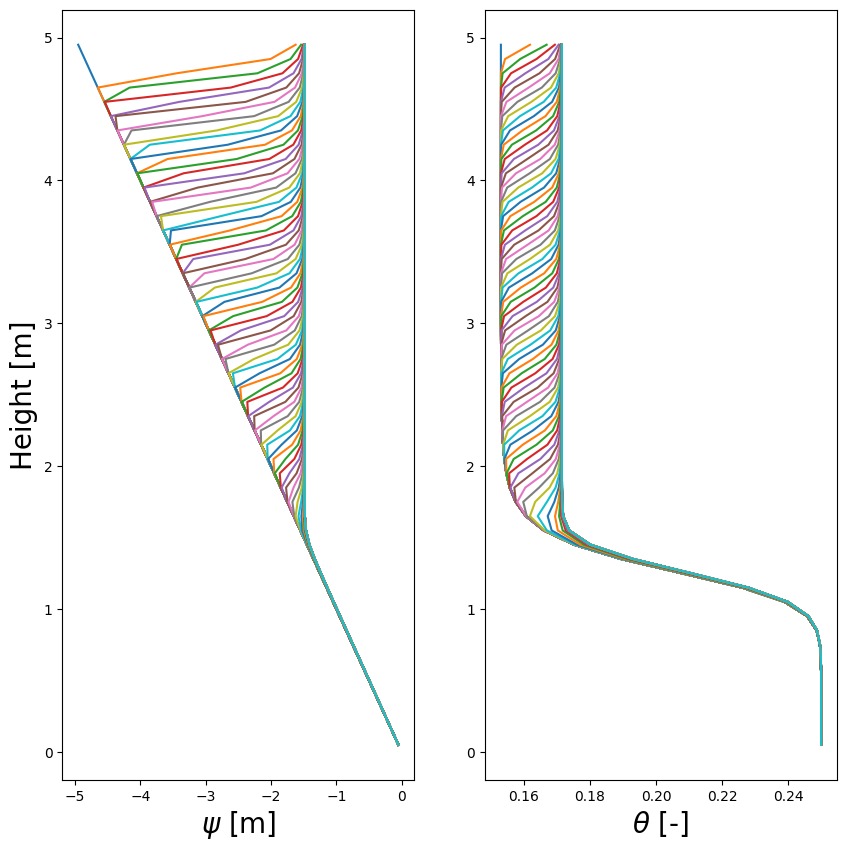

In [6]:
#  Plot vertical profiles. Uncomment to see the plot

pl.rcParams['figure.figsize'] = (10.0, 10.0)
for i in range(0,t.size,1): ### set the time to plot # color horizontal lines are daily measure 
    pl.subplot(121)
    pl.plot(psi[i,:],z)
    pl.subplot(122)
    pl.plot(theta[i,:],z)

pl.subplot(121)
pl.ylabel('Height [m]',fontsize=20) 
 # the Height for soil may seem confusing. Imaging there is a soil column standing on the ground. 
 # The bottom of the soil colum touching the ground is height=0
 # the top of the soil column 5 meters above the ground is height=5
pl.xlabel(r'$\psi$ [m]',fontsize=20)
pl.subplot(122)
pl.xlabel(r'$\theta$ [-]',fontsize=20)

# Figure 3: temporal change of the water flows

Text(0, 0.5, '$m^3$/days')

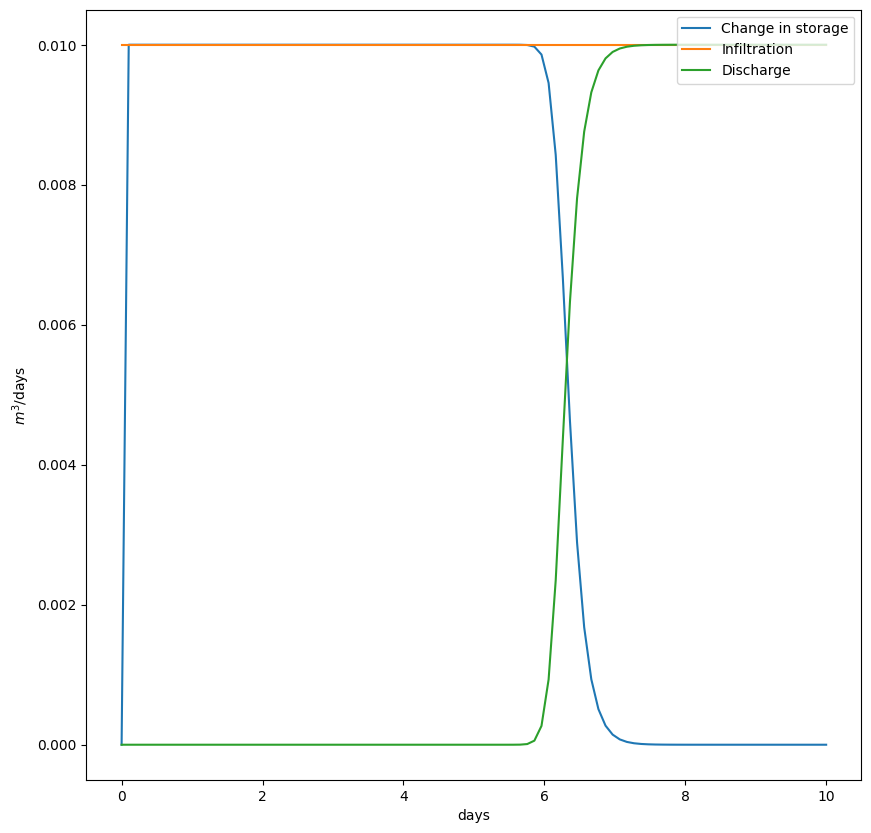

In [7]:
## Plot timeseries, Uncomment to see the plot

dt = t[2]-t[1]
pl.plot(t,dS,label='Change in storage')
pl.plot(t,-qI,label='Infiltration')
pl.plot(t,-qD,label='Discharge')
pl.legend(loc=1)
pl.xlabel('days')
pl.ylabel('$m^3$/days')

# at the end 0 change in storage, theta cst bc infiltration = discharge

## Condition 2. Change the soil type and compare the results
- You may want to change the simuulation duration t to see the change in discharge

In [8]:
# Choose another soil type
p=vg.GuelphLoamDrying() # or p=vg.BeitNetofaClay(), p=vg.GuelphLoamWetting(), p=vg.SiltLoamGE3(), p=vg.TouchetSiltLoam() 

# run the model and plot again

## Condition 3. With the same soil, change the infiltration rate and compare
- You may want to change the simuulation duration t to shorter (if you increase qTop) or longer (if you reduce qTop) to see the change in discharge

In [9]:
qTop=-0.001 # or -0.005 m/day or other number you want to try

# run the model and plot again

## Condition 4. With the same soil, change the boundary condition to free drainage and compare

In [10]:
# run the model and plot again